In [1]:
%load_ext autoreload
%autoreload 1

In [2]:
from pathlib import Path
import off_sample as utils

Using TensorFlow backend.


In [3]:
%run off_sample/utils.py

In [4]:
image_shape = (64, 64, 1)
data_path = Path('./GS/raw_images_rect/')

# Check Hardware and Tools

In [5]:
import tensorflow as tf

In [6]:
tf.__version__

'1.10.1'

In [7]:
from tensorflow.python.client import device_lib

In [8]:
for d in device_lib.list_local_devices():
    print(d)

name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 7011553112477975284

name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 11279997338
locality {
  bus_id: 1
  links {
  }
}
incarnation: 5508569094952288175
physical_device_desc: "device: 0, name: Tesla K80, pci bus id: 0000:00:1e.0, compute capability: 3.7"



In [9]:
from skimage import transform
import imageio
import keras
import numpy as np
import pandas as pd
import sklearn
import matplotlib
keras.__version__, pd.__version__, np.__version__, matplotlib.__version__, sklearn.__version__

('2.2.2', '0.20.2', '1.13.3', '2.0.2', '0.19.2')

In [10]:
from matplotlib import pyplot as plt
%matplotlib inline

# Data Generators

In [11]:
import random

In [12]:
def read_resize(img_path):
    img = imageio.imread(img_path)[:,:,0]
    img = transform.resize(img, image_shape, mode='constant')
    img = img / img.max()
    return img

In [13]:
X_list, y_list, groups = [], [], []

for ds_path in data_path.iterdir():
    for img_class in ['on', 'off']:
        for img_path in (ds_path / img_class).iterdir():
            img = read_resize(img_path)

            X_list.append(img)
            y_list.append(1 if img_class == 'off' else 0)
            groups.append(ds_path.name)

X = np.stack(X_list)
X.setflags(write=False)

y = np.stack(y_list)
y = y.reshape(y.shape + (1,))
y = keras.utils.to_categorical(y, 2)
y.setflags(write=False)

groups = np.stack(groups)
groups.setflags(write=False)

X.shape, y.shape, groups.shape

((18245, 64, 64, 1), (18245, 2), (18245,))

In [14]:
(y[:,0] == 1).sum()

10010

In [15]:
u_groups = np.unique(groups)
len(u_groups)

67

In [16]:
%run off_sample/utils.py

# Train and Test Model

In [17]:
import pickle
import keras
from sklearn.model_selection import GroupKFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import (roc_curve, roc_auc_score, accuracy_score, f1_score,
                             precision_score, recall_score, average_precision_score)

In [18]:
other_u_groups, test_u_groups = train_test_split(u_groups, test_size=0.2, random_state=13)
other_u_groups.shape, test_u_groups.shape

((53,), (14,))

In [19]:
X_other, y_other, groups_other = make_subset(other_u_groups, X, y, groups)
X_test, y_test, groups_test = make_subset(test_u_groups, X, y, groups)

In [20]:
train_u_groups, valid_u_groups = train_test_split(other_u_groups, test_size=0.3, random_state=13)
train_u_groups.shape, valid_u_groups.shape

((37,), (16,))

### Dataset Sampling

In [21]:
import pickle
from pathlib import Path

In [145]:
sample_path = Path('Xygroups_sample.pkl')
if sample_path.exists():
    X_sample, y_sample, groups_sample = pickle.load(open(sample_path, 'rb'))
else:
    X_sample_list = []
    y_sample_list = []
    groups_sample_list = []

    for g in other_u_groups:
        g_off = (groups_other == g)&(y_other[:,1] == 1)
        g_on = (groups_other == g)&(y_other[:,1] == 0)

        on_inds = np.arange(X_other[g_on].shape[0])
        on_sample_inds = np.random.choice(on_inds, int(round(on_inds.shape[0] / 5)), replace=False)
        off_inds = np.arange(X_other[g_off].shape[0])
        off_sample_inds = np.random.choice(off_inds, int(round(off_inds.shape[0] / 5)), replace=False)

        X_sample_list.append(np.concatenate([X_other[g_on][on_sample_inds],
                                             X_other[g_off][off_sample_inds]]))
        y_sample_list.append(np.concatenate([y_other[g_on][on_sample_inds],
                                             y_other[g_off][off_sample_inds]]))
        groups_sample_list.append(np.concatenate([groups_other[g_on][on_sample_inds],
                                                  groups_other[g_off][off_sample_inds]]))

    X_sample = np.concatenate(X_sample_list)
    X_sample.setflags(write=False)
    y_sample = np.concatenate(y_sample_list)
    y_sample.setflags(write=False)
    groups_sample = np.concatenate(groups_sample_list)
    groups_sample.setflags(write=False)

In [146]:
X_sample[0].shape

(64, 64, 1)

In [24]:
# pickle.dump((X_sample, y_sample, groups_sample), open('Xygroups_sample.pkl', 'wb'))

### Transfer Learning

In [569]:
from keras import backend as K
from keras.applications import VGG16
from keras.models import Model, Sequential
from keras.layers import (Activation, BatchNormalization, Conv2D, InputLayer, Dropout, Dense, Flatten)
from keras.metrics import binary_accuracy
from keras.losses import binary_crossentropy
from keras.regularizers import l2
from keras.models import Model
from keras.optimizers import RMSprop, SGD, Adam

In [578]:
def create_fit_tl_model(X_train, y_train, X_valid=None, y_valid=None, verbose=0):
    ### Pretrain Top FC model
    K.clear_session()
    vgg = VGG16(include_top=False, weights='imagenet', input_shape=(*image_shape[:2], 3))
    vgg.trainable = False

    epsilon = 1e-7
    X_mean = X_train.mean(axis=(0, 1, 2))
    X_std = X_train.std(axis=(0, 1, 2))

    def standardize(X):
        return (X - X_mean) / (X_std + epsilon)

    batch_size = 16
    bottleneck_features_train = vgg.predict(standardize(X_train), batch_size=batch_size)
    if X_valid is not None:
        bottleneck_features_valid = vgg.predict(standardize(X_valid), batch_size=batch_size)

    top_model = Sequential()
    top_model.add(InputLayer(input_shape=vgg.output_shape[1:]))
    top_model.add(Flatten())
    top_model.add(Dense(256, kernel_regularizer=l2(l=0.1)))
    top_model.add(BatchNormalization())
    top_model.add(Activation('relu'))
    top_model.add(Dropout(0.75))
    top_model.add(Dense(256, kernel_regularizer=l2(l=0.1)))
    top_model.add(BatchNormalization())
    top_model.add(Activation('relu'))
    top_model.add(Dropout(0.75))
    top_model.add(Dense(2, activation='sigmoid'))

    top_model.compile(optimizer=RMSprop(lr=1e-4),
                      loss=binary_crossentropy,
                      metrics=[binary_accuracy])
    
    if X_valid is not None:
        validation_data = (bottleneck_features_valid, y_valid)
    else:
        validation_data = None
    top_model.fit(bottleneck_features_train, y_train,
                  epochs=10, batch_size=batch_size, verbose=verbose,
                  validation_data=validation_data)

    ### VGG Fine Tuning
    model = Model(inputs=vgg.input, outputs=top_model(vgg.output))

    model.trainable = True
    n = 11
    for i, layer in enumerate(model.layers):
        layer.trainable = i >= n

    model.compile(loss=binary_crossentropy,
                  optimizer=SGD(lr=1e-4, momentum=0.9),
                  metrics=[binary_accuracy])
    
    data_gen = OffSampleImageDataGenerator(
        featurewise_center=True,
        featurewise_std_normalization=True,
        rotation_range=15,
        width_shift_range=0.1,
        height_shift_range=0.1,
        horizontal_flip=True,
        vertical_flip=True,
        zoom_range=0.2
    )
    data_gen.fit(X_train)
    if X_valid is not None:
        X_valid = data_gen.standardize(X_valid)
    
    if X_valid is not None:
        validation_data = (X_valid, y_valid)
    else:
        validation_data = None
    
    batch_size = 32
    epochs = 15
    model.fit_generator(data_gen.flow(X_train, y_train, batch_size=batch_size),
                          validation_data=validation_data,
                          steps_per_epoch=X_train.shape[0]/batch_size,
                          epochs=epochs, verbose=verbose,
                          callbacks=[])
    return model, data_gen

In [575]:
%%time
X_train, y_train, _ = make_subset(train_u_groups, X, y, groups, to_rgb=True)
X_valid, y_valid, _ = make_subset(valid_u_groups, X, y, groups, to_rgb=True)
model, data_gen = create_fit_tl_model(X_train, y_train, X_valid, y_valid, verbose=1)

Train on 9764 samples, validate on 4779 samples
Epoch 1/10
9764/9764 [==============================] - 5s 550us/step - loss: 28.3597 - binary_accuracy: 0.7320 - val_loss: 8.3575 - val_binary_accuracy: 0.8444
Epoch 2/10
9764/9764 [==============================] - 5s 493us/step - loss: 3.6407 - binary_accuracy: 0.9230 - val_loss: 1.4143 - val_binary_accuracy: 0.8796
Epoch 3/10
9764/9764 [==============================] - 5s 495us/step - loss: 0.7002 - binary_accuracy: 0.9619 - val_loss: 0.6549 - val_binary_accuracy: 0.8772
Epoch 4/10
9764/9764 [==============================] - 5s 494us/step - loss: 0.3242 - binary_accuracy: 0.9635 - val_loss: 0.4971 - val_binary_accuracy: 0.8919
Epoch 5/10
9764/9764 [==============================] - 5s 496us/step - loss: 0.2408 - binary_accuracy: 0.9633 - val_loss: 0.5330 - val_binary_accuracy: 0.8732
Epoch 6/10
9764/9764 [==============================] - 5s 494us/step - loss: 0.2185 - binary_accuracy: 0.9638 - val_loss: 0.5613 - val_binary_accuracy

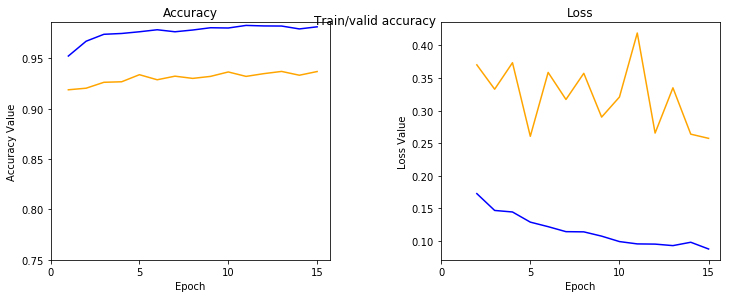

In [576]:
plot_learning_graph([model.history.history], 1)

In [577]:
X_test, y_test, _ = make_subset(test_u_groups, X, y, groups, to_rgb=True)
evaluate_model(X_test, y_test, model, data_gen)

3702/3702 [==============================] - 4s 1ms/step


,f1,prec,recall,acc
on,0.983407,0.973180,0.993851,0.983793
off,0.984161,0.994133,0.974386,0.983793


---

# Final Model Cross Validation

In [581]:
np.unique(groups).shape

(67,)

In [ ]:
%%time

# folds = 5
folds = 67
break_after_first_fold = False
attempts = 1

cv_metrics = []
history_list = []

X_rgb = convert_to_rgb(X)

gkfold = GroupKFold(n_splits=folds)
for fold_i, (train_inds, valid_inds) in enumerate(gkfold.split(X_rgb, y, groups)):
    print(f'Fold: {fold_i}', train_inds.shape, valid_inds.shape)
    
    X_train, y_train = X_rgb[train_inds], y[train_inds]
    X_valid, y_valid = X_rgb[valid_inds], y[valid_inds]
    
    y_pred_avg = np.zeros(y_valid.shape)
    for i in range(attempts):
        print(f'Attempt: {i}')
        
        model, data_gen = create_fit_tl_model(X_train, y_train)
        history_list.append(model.history.history)
        
        y_pred = model.predict(data_gen.standardize(X_valid), verbose=0)
        y_pred_avg += y_pred
        
        metrics = calc_metrics(y_valid, y_pred)
        metrics['fold'] = fold_i
        metrics['attempt'] = i
        cv_metrics.append(metrics)

        print(metrics)
        print()
    
    print('Averaged')
    y_pred_avg /= attempts
    metrics = calc_metrics(y_valid, y_pred_avg)
    metrics['fold'] = fold_i
    metrics['attempt'] = 'avg'
    cv_metrics.append(metrics)  
    print(metrics)
    print()

    if break_after_first_fold:
        break

metrics_df = pd.concat(cv_metrics)
metrics_df.to_msgpack('metrics_df.msgpack')
pickle.dump(history_list, open('history_list.pkl', 'wb'))

Fold: 0 (17769,) (476,)
Attempt: 0


In [566]:
# df = metrics_df.loc['off']
metrics_df[metrics_df.attempt == 'avg'].loc['off'].agg([np.mean, np.std]).T

,mean,std
f1,0.965716,0.016749
prec,0.948214,0.035457
recall,0.984587,0.007608
acc,0.968879,0.014626
fold,2.000000,1.581139


In [567]:
# df = metrics_df.loc['on']
metrics_df[metrics_df.attempt == 'avg'].loc['on'].agg([np.mean, np.std]).T

,mean,std
f1,0.971434,0.013042
prec,0.987144,0.005875
recall,0.956648,0.028447
acc,0.968933,0.014606
fold,2.000000,1.581139


In [568]:
df = metrics_df[metrics_df.attempt == 'avg']
df.groupby(df.index).agg([np.mean, np.std])

f1                prec              recall                 acc  \
         mean       std      mean       std      mean       std      mean   
off  0.965716  0.016749  0.948214  0.035457  0.984587  0.007608  0.968879   
on   0.971434  0.013042  0.987144  0.005875  0.956648  0.028447  0.968933   

              fold            
          std mean       std  
off  0.014626    2  1.581139  
on   0.014606    2  1.581139

In [343]:
# metrics_df[['f1', 'precision', 'recall']].groupby(metrics_df.index).agg((np.mean, np.std))

In [350]:
df = metrics_df.loc['off']
df[df.attempt != 'avg'][['f1', 'prec', 'recall', 'fold', 'attempt']]

,f1,prec,recall,fold,attempt
off,0.863898,0.991649,0.765306,0,0
off,0.947672,0.969918,0.926423,0,1
off,0.879392,0.788085,0.994629,0,2
off,0.943074,0.968847,0.918636,0,3
off,0.959574,0.976376,0.943340,0,4
off,0.796092,0.664098,0.993571,1,0
off,0.911104,0.876485,0.948570,1,1
off,0.886175,0.922523,0.852583,1,2
off,0.899910,0.821024,0.995566,1,3
off,0.918908,0.864258,0.980935,1,4


In [349]:
metrics_df.loc['on']

,f1,prec_recall_score,prec,recall,acc,fold,attempt
on,0.922493,0.993909,0.859440,0.995529,0.901232,0,0
on,0.965055,0.994483,0.950497,0.980067,0.958095,0,1
on,0.895902,0.987037,0.995446,0.814456,0.888253,0,2
on,0.962211,0.993573,0.945513,0.979508,0.954575,0,3
on,0.972749,0.995736,0.961594,0.984165,0.967444,0,4
on,0.973791,0.996368,0.964887,0.982861,0.968764,0,avg
on,0.674141,0.962543,0.987937,0.511633,0.749153,1,0
on,0.906317,0.976876,0.945680,0.870099,0.908773,1,1
on,0.897361,0.969322,0.866573,0.930418,0.892057,1,2
on,0.880000,0.983777,0.994570,0.789100,0.890855,1,3


---